**Image Captioning:**
Image Captioning is the process of generating textual description of an image. It uses
both Natural Language Processing and Computer Vision to generate the captions. The dataset will be in the form [image
→ captions]. The dataset consists of input images and their corresponding output captions.


---


**Encoder:**
The Convolutional Neural Network(CNN) can be thought of as an encoder. The input image is given to CNN to extract
the features. The last hidden state of the CNN is connected to the Decoder.


---


**Decoder:**
The Decoder is a Recurrent Neural Network(RNN) which does language modelling up to the word level. The first time
step receives the encoded output from the encoder and also the <START> vector

# 1.	Import	Libraries/Dataset

In [1]:
# Load libraries
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from tensorflow.keras.models import Sequential, Model
from keras.utils import np_utils
import random
from tensorflow.keras.preprocessing import image, sequence
import matplotlib.pyplot as plt
from os import listdir

# 2. Data	Visualization	and	augmentation

In [2]:
!gdown --id 1A8g74ohdb_5d2fPjc72yF7GxufE9GRcu

Downloading...
From: https://drive.google.com/uc?id=1A8g74ohdb_5d2fPjc72yF7GxufE9GRcu
To: /content/set_1.pkl
2.23MB [00:00, 70.3MB/s]


In [3]:
unpickled_data = pd.read_pickle("./set_1.pkl")
print(unpickled_data)

['2089122314_40d5739aef.jpg#3\tA fluffy , tri-colored dog be run down a road with a paper in its mouth .', '1295671216_cde1b9c9d1.jpg#0\tA crowd of person be stand together on a sidewalk , while one man be take a picture .', '3183195185_cd0ff994a1.jpg#4\tThe man and boy sit on the ground , next to a rocky wall .', '2949353587_64c54e9589.jpg#1\tA brown dog be play with a white fluffy stuff animal .', '361092202_3d70144ebd.jpg#2\tA man hike with a large backpack and two pole near a collection of pointy white rock .', '544301311_5e7d69a517.jpg#1\tTwo girl sit by a doorway on the step .', '3477778668_81ff0a68e0.jpg#1\tA wed photo , the bridesmaid in purple , all of the groomsman jump .', '2561481438_447b852e4d.jpg#3\tA dog play in water .', '1683444418_815f660379.jpg#2\tTwo man be pose for a photograph in front of a fountain in a city .', '241109594_3cb90fe2a3.jpg#2\ta dog swim in the water with a stick in its mouth', '1691573772_1adef8e40e.jpg#0\tA girl in a pink shirt be ride a bicycle i

In [4]:
!gdown --id 1-mPKMpphaKqtT26ZzbR5hCHGedkNyAf1

Downloading...
From: https://drive.google.com/uc?id=1-mPKMpphaKqtT26ZzbR5hCHGedkNyAf1
To: /content/Image_captioning_Dataset.zip
1.12GB [00:05, 211MB/s]


In [5]:
!unzip Image_captioning_Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/Flicker8k_Dataset/._342872408_04a2832a1b.jpg  
  inflating: Flicker8k_Dataset/3429142249_d09a32e291.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429142249_d09a32e291.jpg  
  inflating: Flicker8k_Dataset/3429194423_98e911a101.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429194423_98e911a101.jpg  
  inflating: Flicker8k_Dataset/3429351222_17ae744daf.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429351222_17ae744daf.jpg  
  inflating: Flicker8k_Dataset/3429351964_531de1bf16.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429351964_531de1bf16.jpg  
  inflating: Flicker8k_Dataset/3429391520_930b153f94.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429391520_930b153f94.jpg  
  inflating: Flicker8k_Dataset/3429465163_fb8ac7ce7f.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429465163_fb8ac7ce7f.jpg  
  inflating: Flicker8k_Dataset/3429581486_4556471d1a.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._34295

In [6]:
!nvidia-smi

Sun Sep 19 16:09:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
with open('file.txt', 'w') as f:
    for item in unpickled_data:
        f.write("%s\n" % item)

In [8]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [9]:
# extract features from all images
directory = 'Flicker8k_Dataset'

In [10]:
imagelist = []
for name in listdir(directory):
  imagelist.append(name)

In [11]:
filename = 'file.txt'
doc = load_doc(filename)
desclist = []
for line in doc.split('\n'):
  tokens = line.split()
  if len(line) < 2:
    continue
  # take the first token as the image id, the rest as the description
  image_id = tokens[0]
  
  image_id = image_id.split('#')[0]
  desclist.append(image_id)

In [12]:
#removing file that is not present in the dataset
img = list(set(desclist) - set(imagelist))
img

['2258277193_586949ec62.jpg.1']

In [13]:
with open('Flickr8k.token.txt', 'w') as f:
  for item in unpickled_data:
    itemlist = item.split('#')
    if(itemlist[0] != img[0]):
      f.write("%s\n" % item)

In [14]:
with open('Flickr8k.images.txt', 'w') as f:
    for item in imagelist:
        f.write("%s\n" % item)

In [15]:
# load image_id
def train_val_split(dataset, train_size=0.8):

	# return split dataset as two new sets
  train_size = int(len(dataset) * train_size)

  training_data = dataset[:train_size]
  test_data = dataset[train_size:]
  
  return training_data, test_data

In [16]:
# Split the dataset into training and validation sets
train_data, test_data = train_val_split(imagelist)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(test_data))

Number of training samples:  6472
Number of validation samples:  1619


In [17]:
with open('Flickr_8k.trainImages.txt', 'w') as f:
    for item in train_data:
        f.write("%s\n" % item)

In [18]:
with open('Flickr_8k.testImages.txt', 'w') as f:
    for item in test_data:
        f.write("%s\n" % item)

In [19]:
# Load data
images_dir = os.listdir("Flicker8k_Dataset/")

images_path = 'Flicker8k_Dataset/'
captions_path = 'Flickr8k.token.txt'
train_path = 'Flickr_8k.trainImages.txt'
test_path = 'Flickr_8k.testImages.txt'

captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_test = open(test_path, 'r').read().split("\n")

In [20]:
# Loading captions as values and images as key in dictionary
tokens = {}

for ix in range(len(captions)-1):
    temp = captions[ix].split("#")
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][2:])
    else:
        tokens[temp[0]] = [temp[1][2:]]

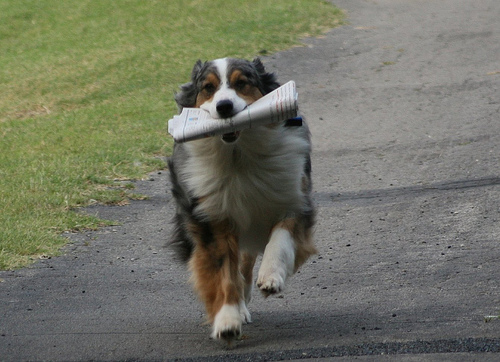

A fluffy , tri-colored dog be run down a road with a paper in its mouth .
A dog run with a newspaper in its mouth .
A dog with a newspaper in his mouth run down a paved path .


In [21]:
# displaying an image and captions given to it
temp = captions[0].split("#")
from IPython.display import Image, display
z = Image(filename=images_path+temp[0])
display(z)

for ix in range(len(tokens[temp[0]])):
    print(tokens[temp[0]][ix])

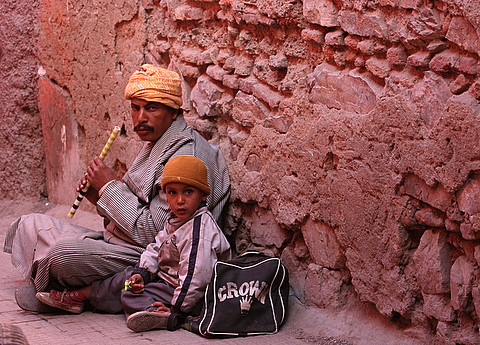

The man and boy sit on the ground , next to a rocky wall .
A man and a small boy sit and rest against a stone wall .


In [22]:
# displaying an image and captions given to it
temp = captions[2].split("#")
from IPython.display import Image, display
z = Image(filename=images_path+temp[0])
display(z)

for ix in range(len(tokens[temp[0]])):
    print(tokens[temp[0]][ix])

In [23]:
# Creating train, test and validation dataset files with header as 'image_id' and 'captions'
dataset = open('flickr_8k.images.txt','wb')
dataset.write(b"image_id\tcaptions\n")

18

In [24]:
# Populating the above created files for train, test and validation dataset with image ids and captions for each of these images
for img in imagelist:
  try:
     for capt in tokens[img]:
       caption = "<start> "+ capt + " <end>"
       dataset.write((img+"\t"+caption+"\n").encode())
       dataset.flush()
  except:
      continue
dataset.close()

# 3.	Model	Building

In [25]:
# Loading 50 layer Residual Network Model and getting the summary of the model
from IPython.core.display import display, HTML
display(HTML("""<a href="http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006">ResNet50 Architecture</a>"""))
model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')
model.summary()
# Note: For more details on ResNet50 architecture you can click on hyperlink given below

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [26]:
# Helper function to process images
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [44]:
train_data = {}
ctr=0
for ix in imagelist:
    if ix == "":
        continue
    if ctr >= 6000:
        break
    ctr+=1
    if ctr%1000==0:
        print(ctr)
    path = images_path + ix
    img = preprocessing(path)
    pred = model.predict(img).reshape(2048)
    train_data[ix] = pred

1000
2000
3000
4000
5000
6000


In [45]:
# opening train_encoded_images.p file and dumping it's content
with open( "train_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(train_data, pickle_f )

In [46]:
# Loading image and its corresponding caption into a dataframe and then storing values from dataframe into 'ds'
pd_dataset = pd.read_csv("flickr_8k.images.txt", delimiter='\t')
ds = pd_dataset.values
print("train: ", ds.shape)

train:  (24996, 2)


In [47]:
pd_dataset.head()

,image_id,captions
0,2937942758_712be5c610.jpg,<start> A person be stand near a row of identi...
1,2937942758_712be5c610.jpg,<start> A woman be stand outside near many bic...
2,2937942758_712be5c610.jpg,<start> A woman stand near a row of identical ...
3,2937942758_712be5c610.jpg,<start> A woman stand near a bike rack . <end>
4,433810429_a4da0eac50.jpg,<start> Three person backpack across a large s...


In [48]:
# Storing all the captions from ds into a list
sentences = []
for ix in range(ds.shape[0]):
    sentences.append(ds[ix, 1])
    
print(len(sentences))

24996


In [49]:
# First 5 captions stored in sentences
sentences[:5]

['<start> A person be stand near a row of identical red and white bicycle . <end>',
 '<start> A woman be stand outside near many bicycle . <end>',
 '<start> A woman stand near a row of identical red bicycle . <end>',
 '<start> A woman stand near a bike rack . <end>',
 '<start> Three person backpack across a large snowy and rocky field . <end>']

In [50]:
# Splitting each captions stored in 'sentences' and storing them in 'words' as list of list
words = [i.split() for i in sentences]

In [51]:
# Creating a list of all unique words
unique = []
for i in words:
    unique.extend(i)
unique = list(set(unique))

print(len(unique))

vocab_size = len(unique)

5993


In [52]:
# Vectorization
word_2_indices = {val:index for index, val in enumerate(unique)}
indices_2_word = {index:val for index, val in enumerate(unique)}

In [53]:
word_2_indices['UNK'] = 0
word_2_indices['raining'] = vocab_size

In [54]:
indices_2_word[0] = 'UNK'
indices_2_word[vocab_size] = 'raining'

In [55]:
vocab_size = len(word_2_indices.keys())
print(vocab_size)

5995


In [56]:
with open( "word_2_indices.pkl", "wb" ) as pickle_f:
    pickle.dump(word_2_indices, pickle_f ) 

In [57]:
with open( "indices_2_word.pkl", "wb" ) as pickle_f:
    pickle.dump(indices_2_word, pickle_f ) 

In [58]:
max_len = 0

for i in sentences:
    i = i.split()
    if len(i) > max_len:
        max_len = len(i)

print(max_len)

40


In [59]:
padded_sequences, subsequent_words = [], []

for ix in range(ds.shape[0]):
    partial_seqs = []
    next_words = []
    text = ds[ix, 1].split()
    text = [word_2_indices[i] for i in text]
    for i in range(1, len(text)):
        partial_seqs.append(text[:i])
        next_words.append(text[i])
    padded_partial_seqs = sequence.pad_sequences(partial_seqs, max_len, padding='post')

    next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)
    
    #Vectorization
    for i,next_word in enumerate(next_words):
        next_words_1hot[i, next_word] = 1
        
    padded_sequences.append(padded_partial_seqs)
    subsequent_words.append(next_words_1hot)
    
padded_sequences = np.asarray(padded_sequences)
subsequent_words = np.asarray(subsequent_words)

print(padded_sequences.shape)
print(subsequent_words.shape)

(24996,)
(24996,)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [60]:
print(padded_sequences[0])

[[ 176    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [ 176  550    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [ 176  550 2517    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [ 176  550 2517 4442    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [ 176  550 2517 4442 3206    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

In [61]:
num_of_images = 6000

In [62]:
captions = np.zeros([0, max_len])
next_words = np.zeros([0, vocab_size])

In [63]:
for ix in range(num_of_images):
    captions = np.concatenate([captions, padded_sequences[ix]])
    next_words = np.concatenate([next_words, subsequent_words[ix]])

np.save("captions.npy", captions)
np.save("next_words.npy", next_words)

print(captions.shape)
print(next_words.shape)

(76183, 40)
(76183, 5995)


In [64]:
with open('train_encoded_images.p', 'rb') as f:
    encoded_images = pickle.load(f, encoding="bytes")

In [65]:
imgs = []
for ix in range(ds.shape[0]):
  if ds[ix, 0] in encoded_images.keys():
    #print(ix, encoded_images[ds[ix, 0].encode()])
    imgs.append(list(encoded_images[ds[ix, 0]]))

imgs = np.asarray(imgs)
print(imgs.shape)

(18514, 2048)


In [66]:
images = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        images.append(imgs[ix])
        
images = np.asarray(images)

np.save("images.npy", images)

print(images.shape)

(76183, 2048)


In [67]:
image_names = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        image_names.append(ds[ix, 0])
        
image_names = np.asarray(image_names)

np.save("image_names.npy", image_names)

print(len(image_names))

76183


# 4. Model	Compilation

In [68]:
captions = np.load("captions.npy")
next_words = np.load("next_words.npy")

print(captions.shape)
print(next_words.shape)

(76183, 40)
(76183, 5995)


In [69]:
images = np.load("images.npy")

print(images.shape)

(76183, 2048)


In [70]:
imag = np.load("image_names.npy")
        
print(imag.shape)

(76183,)


In [71]:
embedding_size = 128
#max_len = 40
#vocab_size = 5995

In [72]:
def initialise():
  
  image_model = Sequential()
  
  image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
  image_model.add(RepeatVector(max_len))

  language_model = Sequential()
  
  language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
  language_model.add(LSTM(128, return_sequences=True, recurrent_regularizer=regularizers.l1(1e-3))) #first lstm layer
  language_model.add(LSTM(256, return_sequences=True, recurrent_regularizer=regularizers.l1(1e-3))) #second lstm layer
  language_model.add(TimeDistributed(Dense(embedding_size)))

  conca = Concatenate()([image_model.output, language_model.output])
  x = LSTM(64, return_sequences=True, recurrent_regularizer=regularizers.l1(1e-3))(conca) #third lstm layer
  x = LSTM(128, return_sequences=True, recurrent_regularizer=regularizers.l1(1e-3))(x)    #fourth lstm layer
  x = LSTM(256, return_sequences=False, recurrent_regularizer=regularizers.l1(1e-3))(x)   #fifth lstm layer
  x = Dense(vocab_size)(x)
  x = Dropout(0.5)(x) #dropout
  out = Activation('softmax')(x)
  model = Model(inputs=[image_model.input, language_model.input], outputs = out)
  
  return model

Normally, we apply the dropout before the activation to dropout the input elements in the preceding layer

In [73]:
for i in [1,0.1,0.01,0.001,0.0001,0.00001]:
  model = initialise()
  model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=i), metrics=['accuracy'])
  print("Learning rate = ",i)
  model.fit([images, captions], next_words, batch_size=512, epochs=1)

Learning rate =  1
149/149 [==============================] - 18s 62ms/step - loss: 3869.0420 - accuracy: 0.0129
Learning rate =  0.1
149/149 [==============================] - 18s 62ms/step - loss: 65.0059 - accuracy: 0.0155
Learning rate =  0.01
149/149 [==============================] - 18s 62ms/step - loss: 10.8767 - accuracy: 0.0711
Learning rate =  0.001
149/149 [==============================] - 18s 62ms/step - loss: 9.5037 - accuracy: 0.0729
Learning rate =  0.0001
149/149 [==============================] - 18s 63ms/step - loss: 21.1821 - accuracy: 0.0751
Learning rate =  1e-05
149/149 [==============================] - 18s 62ms/step - loss: 26.6307 - accuracy: 0.0467


Chosing learning rate = 0.001 as it gives the better accuracy.

In [74]:
#initialise the model
model = initialise()

# summary of model
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_6_input (InputLayer)  [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 40, 128)      767360      embedding_6_input[0][0]          
__________________________________________________________________________________________________
dense_18_input (InputLayer)     [(None, 2048)]       0                                            
__________________________________________________________________________________________________
lstm_30 (LSTM)                  (None, 40, 128)      131584      embedding_6[0][0]                
____________________________________________________________________________________________

In [75]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), metrics=['accuracy'])

In [76]:
from time import time
start = time()
hist = model.fit([images, captions], next_words, batch_size=512, epochs=300,validation_split=0.2)
totaltime = time() - start

Epoch 1/300
120/120 [==============================] - 19s 90ms/step - loss: 10.0362 - accuracy: 0.0732 - val_loss: 6.4171 - val_accuracy: 0.0874
Epoch 2/300
120/120 [==============================] - 8s 69ms/step - loss: 7.3358 - accuracy: 0.0752 - val_loss: 6.0974 - val_accuracy: 0.0874
Epoch 3/300
120/120 [==============================] - 8s 69ms/step - loss: 7.2933 - accuracy: 0.0765 - val_loss: 5.9688 - val_accuracy: 0.0715
Epoch 4/300
120/120 [==============================] - 8s 69ms/step - loss: 7.2801 - accuracy: 0.0782 - val_loss: 5.8548 - val_accuracy: 0.0770
Epoch 5/300
120/120 [==============================] - 8s 69ms/step - loss: 7.2866 - accuracy: 0.0765 - val_loss: 6.1506 - val_accuracy: 0.0907
Epoch 6/300
120/120 [==============================] - 8s 69ms/step - loss: 7.1455 - accuracy: 0.1143 - val_loss: 5.7617 - val_accuracy: 0.1877
Epoch 7/300
120/120 [==============================] - 8s 69ms/step - loss: 6.9815 - accuracy: 0.1427 - val_loss: 5.6203 - val_accurac

In [77]:
model.save("model.h5")

In [78]:
model.save_weights("model_weights.h5")

In [79]:
print("Time taken for training", totaltime,"seconds")

Time taken for training 2511.1864428520203 seconds


In [80]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


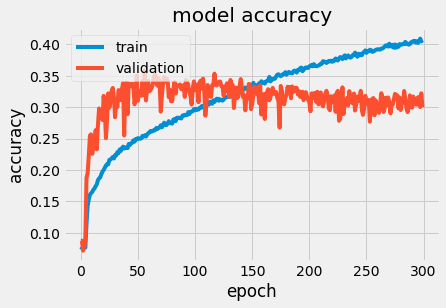

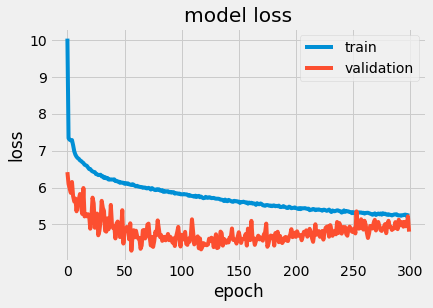

In [83]:
plt.style.use('fivethirtyeight')

#  "Accuracy"
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
print("""

""")
# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

### 6.	Model	Evaluation

In [84]:
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [85]:
def get_encoding(model, img):
    image = preprocessing(img)
    pred = model.predict(image).reshape(2048)
    return pred

In [86]:
resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

In [127]:
from google.colab import files as FILE
import os
import requests

img_data = requests.get("https://i.pinimg.com/originals/b5/3f/6e/b53f6e162c1d239b748b54c2b46ad324.jpg").content
with open('test_image.jpg', 'wb') as handler:
    handler.write(img_data)

In [128]:
img = "test_image.jpg"

test_img = get_encoding(resnet, img)

In [129]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word_2_indices[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        preds = model.predict([np.array([image]), np.array(par_caps)])
        word_pred = indices_2_word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

Argmax_Search = predict_captions(test_img)

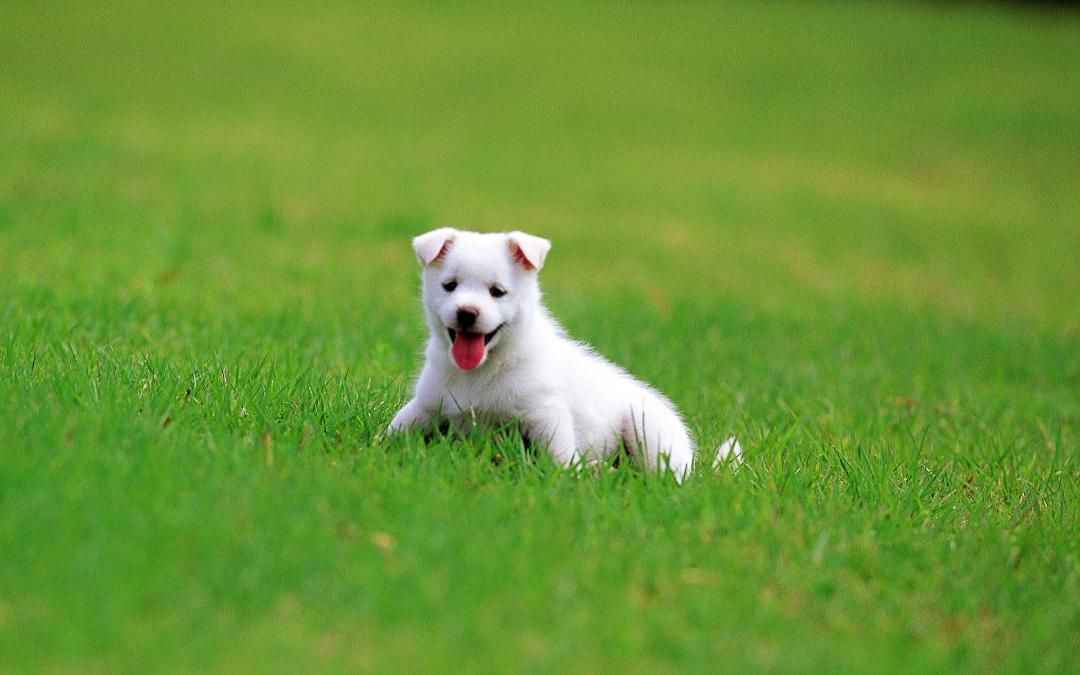

In [130]:
from PIL import Image
im = Image.open(img) 
im

In [131]:
print(Argmax_Search)

A dog run through a yard .
